In [1]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

   ---------------------------------------- 258.3/258.3 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 301.8/301.8 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


All done


In [2]:
Healthy = os.listdir(r'C:\Users\anubh\OneDrive\Documents\Individual Data Science Projects\Detecting Retinopathy Diabetes\gaussian_filtered_images\No_DR')
Mild = os.listdir(r'C:\Users\anubh\OneDrive\Documents\Individual Data Science Projects\Detecting Retinopathy Diabetes\gaussian_filtered_images\Mild')
Moderate = os.listdir(r'C:\Users\anubh\OneDrive\Documents\Individual Data Science Projects\Detecting Retinopathy Diabetes\gaussian_filtered_images\Moderate')
Proliferate = os.listdir(r'C:\Users\anubh\OneDrive\Documents\Individual Data Science Projects\Detecting Retinopathy Diabetes\gaussian_filtered_images\Proliferate_DR')
Severe = os.listdir(r'C:\Users\anubh\OneDrive\Documents\Individual Data Science Projects\Detecting Retinopathy Diabetes\gaussian_filtered_images\Severe')

In [3]:
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

Number of Healty images : 1805 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 999 
______________________________

Number of Proliferate images : 295 
______________________________

Number of severe images : 193 
______________________________



In [5]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'C:\Users\anubh\OneDrive\Documents\Individual Data Science Projects\Detecting Retinopathy Diabetes\train.csv')

diagnosis_dict_binary = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    4: 1
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,1,Moderate
1,001639a390f0,4,1,Proliferate_DR
2,0024cdab0c1e,1,1,Mild
3,002c21358ce6,0,0,No_DR
4,005b95c28852,0,0,No_DR


In [8]:
sdir=r'C:\Users\anubh\OneDrive\Documents\Individual Data Science Projects\Detecting Retinopathy Diabetes\gaussian_filtered_images'
classlist=os.listdir(sdir)    
filepaths=[]
labels=[]    
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)        
            filepaths.append(fpath)
            labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    

In [9]:
df

,filepaths,labels
0,C:\Users\anubh\OneDrive\Documents\Individual D...,Mild
1,C:\Users\anubh\OneDrive\Documents\Individual D...,Mild
2,C:\Users\anubh\OneDrive\Documents\Individual D...,Mild
3,C:\Users\anubh\OneDrive\Documents\Individual D...,Mild
4,C:\Users\anubh\OneDrive\Documents\Individual D...,Mild
...,...,...
3657,C:\Users\anubh\OneDrive\Documents\Individual D...,Severe
3658,C:\Users\anubh\OneDrive\Documents\Individual D...,Severe
3659,C:\Users\anubh\OneDrive\Documents\Individual D...,Severe
3660,C:\Users\anubh\OneDrive\Documents\Individual D...,Severe


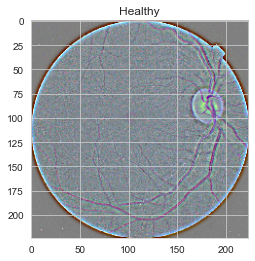

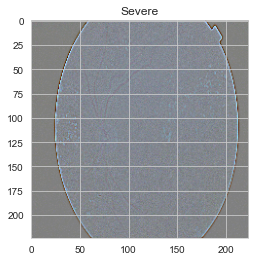

In [10]:
img1 = cv2.imread(r"C:\Users\anubh\OneDrive\Documents\Individual Data Science Projects\Detecting Retinopathy Diabetes\gaussian_filtered_images\No_DR\0a4e1a29ffff.png")
plt.imshow(img1)
plt.title("Healthy")
plt.show()

img2 = cv2.imread(r"C:\Users\anubh\OneDrive\Documents\Individual Data Science Projects\Detecting Retinopathy Diabetes\gaussian_filtered_images\Severe\0cb14014117d.png")
plt.imshow(img2)
plt.title("Severe")
plt.show()

# Down sample class "Healthy" from 1805 to 1500

In [11]:
sample_list=[]
max_size= 1500
groups=df.groupby('labels')
for label in df['labels'].unique():                 
    group=groups.get_group(label)
    sample_count=len(group)    
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))     
print (df['labels'].value_counts())

3357
labels
No_DR             1500
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64


In [12]:
working_dir=r'./'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [13]:
target=1500 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=df.groupby('labels') # group by class
for label in df['labels'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(224,224), class_mode=None,
                                        batch_size=1, shuffle=False, save_to_dir=target_dir, save_prefix='aug-',
                                        save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images) 

Found 370 validated image filenames.
Found 999 validated image filenames.
Found 295 validated image filenames.
Found 193 validated image filenames.


In [15]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)     
    flist=os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)
ndf=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
#ndf=df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)


print (df['labels'].value_counts()) 
print(aug_df['labels'].value_counts())
print (ndf['labels'].value_counts()) 

labels
No_DR             1500
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64
labels
Severe            1307
Proliferate_DR    1205
Mild              1130
Moderate           501
Name: count, dtype: int64
labels
Mild              1500
Moderate          1500
No_DR             1500
Proliferate_DR    1500
Severe            1500
Name: count, dtype: int64


In [16]:
ndf.head()

,filepaths,labels
0,C:\Users\anubh\OneDrive\Documents\Individual D...,Mild
1,C:\Users\anubh\OneDrive\Documents\Individual D...,Mild
2,C:\Users\anubh\OneDrive\Documents\Individual D...,Mild
3,C:\Users\anubh\OneDrive\Documents\Individual D...,Mild
4,C:\Users\anubh\OneDrive\Documents\Individual D...,Mild


In [17]:
train_split=.8
valid_split=.1
dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(ndf, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df),'  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  6000   test_df length:  750   valid_df length:  750


In [18]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img 
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  75   test steps:  10
Found 6000 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.


In [19]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='green', fontsize=16)
        plt.axis('off')
    plt.show()

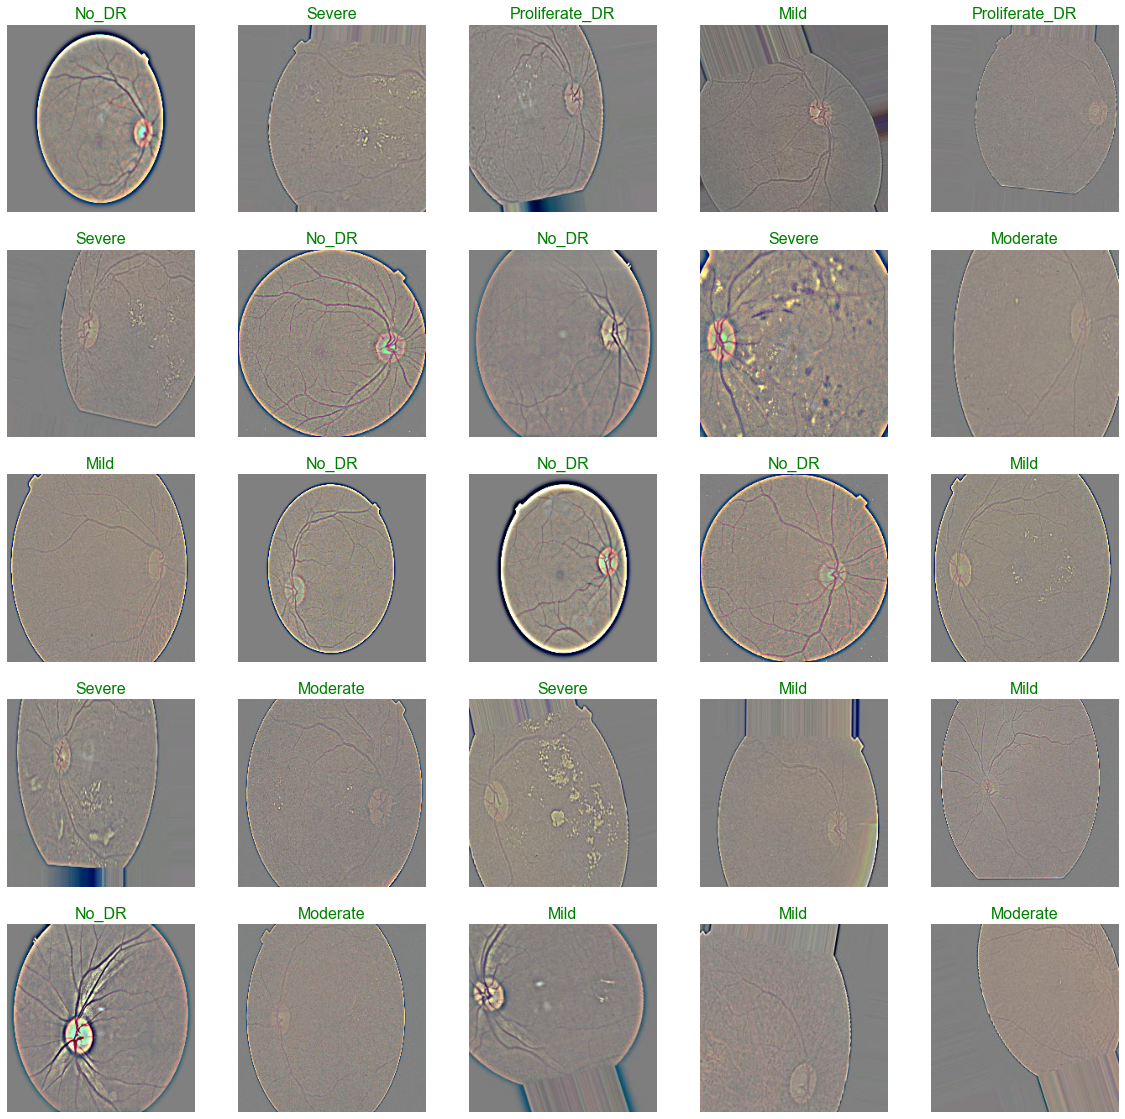

In [20]:
show_image_samples(train_gen)

In [21]:
# Define number of classes 
n_classes = len(list(train_gen.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate

43941136/43941136 [==============================] - 21s 0us/step


In [22]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))

In [23]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                        

In [26]:
epochs = 50
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/50
150/150 [==============================] - 1796s 11s/step - loss: 1.6603 - acc: 0.4132 - val_loss: 1.2240 - val_acc: 0.5133
Epoch 2/50
150/150 [==============================] - 1763s 12s/step - loss: 1.1833 - acc: 0.5237 - val_loss: 0.9934 - val_acc: 0.5867
Epoch 3/50
 36/150 [======>.......................] - ETA: 22:18 - loss: 1.0985 - acc: 0.5472

KeyboardInterrupt: 

# Evaluation

In [ ]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)

    
# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

# Visualise Model Performance

In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()